**A. Import and understand the data**

In [1]:
#import the required libraries
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.2'

In [2]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Mount Google Drive - This is a common step for loading the dataset for all the three types of models.
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import libraries and declare variables**

In [32]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

image_dir= r"gdrive/My Drive/AIML/Projects/Capstone/Car Images/Train Images"
anno_dir =r"gdrive/My Drive/AIML/Projects/Capstone"
carname_dir=r"gdrive/My Drive/AIML/Projects/Capstone"

**Custom Functions - Read Images**

**read_images_from_dir()**

This function is invoked from read_images() function. This will check whether the files inside a sub folder is a jpg image, if yes, will read the labels, images and image path to list variables. After reading the entire set of files, it will return the lists to the read_images()

In [5]:
def read_images_from_dir(base_dir, folder):
    labels = []
    images = []
    image_names=[]
    path_folder = os.path.join(image_dir, folder)
    if(os.path.isdir(path_folder)):
      files_directory = os.listdir(path_folder)
      for file in files_directory:
          if file.endswith('.jpg'):
              labels.append(folder)
              images.append(os.path.join(path_folder, file))
              image_names.append(file)
    return labels, images,image_names

**read_images()**

This function will read the image directory passed to the function. This will check whether the path is a directory, if yes, will iterate through all the subfolders. While iterating, it will call another custom function to read all  the images, labels and path details and get into variables. The retrieved variables are appended then to an array that will be the final output of all images read from the various sub folders of the image directory

In [6]:
def read_images(base_dir):
    labels = []
    images = []
    image_names_lst=[]
    if(os.path.isdir(image_dir)):
      folders = os.listdir(image_dir)
      for folder in folders:
          labels_folder, images_folder,image_names = read_images_from_dir(base_dir, folder)

          labels.extend(labels_folder)
          images.extend(images_folder)
          image_names_lst.extend(image_names)

      return labels, images,image_names_lst

**Invoke the read_images()**

In [7]:
labels,images,image_names_lst=read_images(image_dir)

**Append everything to a dataframe**

In [8]:

carsdf_train =  pd.DataFrame(np.column_stack([labels, images, image_names_lst]), 
                               columns=['Model', 'Images', 'Image Name'])

**Data Understanding**

**1. Visualize the images from the carsdf_train**

**print_images_of_a_model()**

This function will accept a model name and will print few images from the carsdf_train for the model

In [9]:
def print_images_of_a_model(modelname):
  subset_carsdf=carsdf_train['Model']
  result = carsdf_train[carsdf_train['Model'] ==modelname]
  print(result.shape)
  return result 

**Invoke the print_images_of_a_model and plot it using pyplot**

(45, 3)


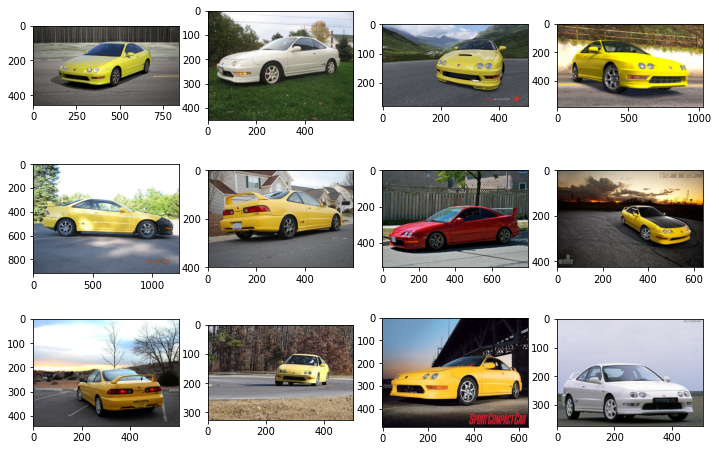

In [61]:
result=print_images_of_a_model("Acura Integra Type R 2001")

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

cols=3
rows=4

# plt.title("Car Images")
fig, axarr = plt.subplots(cols,rows, figsize=(12, 8))
index=0

for i in range(0,cols):
  for j in range(0,rows):
        axarr[i,j].imshow(mpimg.imread(result.iloc[index].Images))
        index=index+1

**Check whether the data is balanced for Models**

**a. Unique Models**

In [11]:
import pandas as pd
df_unique= pd.DataFrame(labels,columns=["CarModel"])
df_unique_count = pd.DataFrame(df_unique.groupby(['CarModel'])['CarModel'].count().reset_index(name='Count'))
df_unique_count.nlargest(n=10, columns=[ 'Count'])

,CarModel,Count
119,GMC Savana Van 2012,68
75,Chrysler 300 SRT-8 2010,49
160,Mercedes-Benz 300-Class Convertible 1993,48
166,Mitsubishi Lancer Sedan 2012,48
58,Chevrolet Corvette ZR1 2012,47
143,Jaguar XK XKR 2012,47
20,Audi S6 Sedan 2011,46
40,Bentley Continental GT Coupe 2007,46
90,Dodge Durango SUV 2007,46
97,Eagle Talon Hatchback 1998,46


**Models with least count**

In [12]:
df_unique_count.nsmallest(n=10, columns=[ 'Count'])

,CarModel,Count
129,Hyundai Accent Sedan 2012,24
98,FIAT 500 Abarth 2012,28
157,Maybach Landaulet Convertible 2012,29
59,Chevrolet Express Cargo Van 2007,30
175,Rolls-Royce Phantom Drophead Coupe Convertible...,31
2,Acura RL Sedan 2012,32
9,Aston Martin Virage Convertible 2012,33
44,Bugatti Veyron 16.4 Convertible 2009,33
141,Infiniti QX56 SUV 2011,33
30,BMW ActiveHybrid 5 Sedan 2012,34


**Data distribution on count-Models**

In [13]:
df_unique_count.describe()

,Count
count,196.00000
mean,41.55102
std,4.33382
min,24.00000
25%,39.75000
50%,42.00000
75%,44.00000
max,68.00000


**Imbalance Data**

We could see from the about details that there is an imbalance in the count of each models that is ranging from 68 to 24.

**Data Augmentation** : Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. The intent is to expand the training dataset with new, plausible examples. 

For example, a horizontal flip of a picture of a car may make sense, because the photo could have been taken from the left or right. A vertical flip of the photo of a car does not make sense and would probably not be appropriate given that the model is very unlikely to see a photo of an upside down car.

Augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. The choice of the specific data augmentation techniques used for a training dataset must be chosen carefully and within the context of the training dataset and knowledge of the problem domain.

**Note** : Image data augmentation is typically only applied to the training dataset, and not to the validation or test dataset.

In [14]:
result=print_images_of_a_model("Acura Integra Type R 2001")

(45, 3)


**a. Horizontal and Vertical Shift Augmentation**

A shift to an image means moving all pixels of the image in one direction, such as horizontally or vertically, while keeping the image dimensions the same.

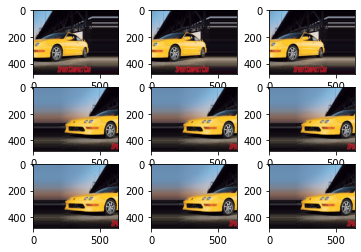

In [15]:
# example of horizontal shift image augmentation
# load the image
# img = load_img(result[0].Images)
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

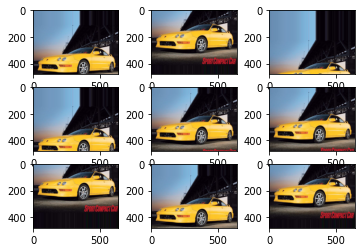

In [16]:
# example of vertical shift image augmentation
# load the image
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

**b. Horizontal and Vertical Flip Augmentation**

An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

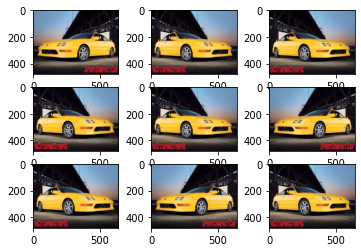

In [17]:
# example of horizontal flip image augmentation
# load the image
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

**c. Random Rotation Augmentation**

A rotation augmentation randomly rotates the image clockwise by a given number of degrees from 0 to 360.

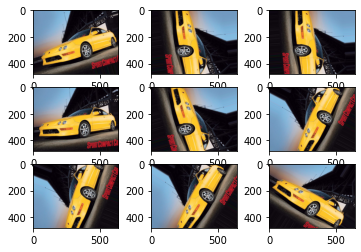

In [18]:
# example of random rotation image augmentation
# load the image
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

**d. Random Brightness Augmentation**

The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.

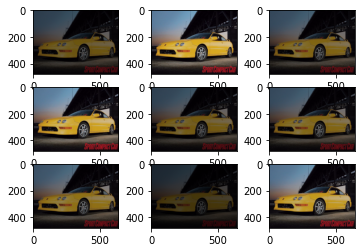

In [19]:
# example of brighting image augmentation
# load the image
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

**e. Random Zoom Augmentation**

A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.

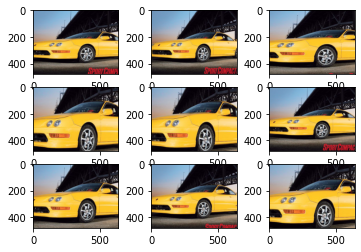

In [20]:
# example of zoom image augmentation
# load the image
img = mpimg.imread(result.iloc[10].Images)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

**Prepare Images for Models**

In [30]:
flat_data_arr=[] #input array
target_arr=[] #output array

In [54]:
IMG_SIZE = 180

resize_and_rescale = tensorflow.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)#,
  # layers.Flatten()
])

In [44]:
def flatten(*x):
  return tensorflow.keras.ata.Dataset.from_tensor_slices([i for i in x])

In [57]:
# for i in range(0,len(carsdf_train)+1):
for i in range(0,11):
  img_array=imread(carsdf_train.iloc[i].Images)
  # img_resized = resize_and_rescale(image)
  # print("Min and max pixel values:", img_resized.numpy().min(), img_resized.numpy().max())
  flat_data_arr.append(img_array)
  
  target_arr.append(carsdf_train.iloc[i].Model)

**Verify that the resize is complete**

In [58]:
# # flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
X_train=pd.DataFrame(flat_data_arr) #dataframe
X_train['Target']=target
X=X_train.iloc[:,:-1] #input data 
y=X_train.iloc[:,-1] #output data

In [59]:
X.shape

(724, 1)

In [60]:
X[0]

0      (((tf.Tensor(0.4666667, shape=(), dtype=float3...
1      (((tf.Tensor(0.4666667, shape=(), dtype=float3...
2      (((tf.Tensor(0.4666667, shape=(), dtype=float3...
3      (((tf.Tensor(0.4666667, shape=(), dtype=float3...
4      (((tf.Tensor(0.4666667, shape=(), dtype=float3...
                             ...                        
719    [[[255, 255, 255], [255, 255, 255], [255, 255,...
720    [[[255, 255, 255], [255, 255, 255], [255, 255,...
721    [[[255, 255, 255], [255, 255, 255], [255, 255,...
722    [[[102, 89, 45], [103, 90, 46], [104, 91, 47],...
723    [[[99, 114, 121], [98, 113, 120], [96, 109, 11...
Name: 0, Length: 724, dtype: object